
### 1. Data Understanding

- Mengimpor pustaka pandas untuk manipulasi data.
- Memuat dataset Tempat-Wisata-Toba-Preprocessing.csv ke dalam DataFrame dataset.
- Drop Kolom yang tidak relevan
- Mengisi nilai kosong pada kolom **Reviews** dengan string kosong untuk menghindari error.
- Menampilkan beberapa baris pertama dari dataset untuk memverifikasi hasil pembersihan data.


In [1]:
import pandas as pd  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import mean_squared_error, mean_absolute_error  
from sklearn.metrics import precision_score, recall_score, accuracy_score  

def load_and_clean_data(file_path):  
    try:  
        dataset = pd.read_csv(file_path)  
        dataset = dataset.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], errors='ignore')  
        dataset['Reviews'] = dataset['Reviews'].fillna('')  
        return dataset  
    except FileNotFoundError:  
        print(f"File not found: {file_path}")  
        return None  

file_path = 'Tempat-Wisata-Toba-Preprocessing.csv'  
dataset = load_and_clean_data(file_path)  
dataset.head()

,address,PlaceID,Nama_tempat_wisata,Category,ReviewerId,Rating,Reviews
0,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.126030e+20,5.0,
1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.119090e+20,5.0,bagus
2,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.078860e+20,5.0,
3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.130720e+20,5.0,sangat menyenagkan
4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.061730e+20,5.0,bebas foto dimana aja cuma 2k


- Mengimpor pustaka yang diperlukan dan mendefinisikan fungsi load_and_clean_data yang mencoba memuat dataset dari file CSV dan menangani kesalahan jika file tidak ditemukan.
- Fungsi ini menghapus kolom yang tidak relevan dan mengisi nilai kosong pada kolom Reviews dengan string kosong.
- Hasil tampilan dari dataset.head() menunjukkan 5 baris pertama dari dataset yang telah dibersihkan.


### 2. Combining and Tokenizing Features

- Membuat kolom baru **Combined** yang menggabungkan informasi dari **Category**, **Reviews**, dan **Nama_tempat_wisata**.
- Mengonversi kolom ini menjadi token unik menggunakan tokenisasi sederhana berbasis spasi.


In [2]:
dataset['Combined'] = (  
    dataset['Category'] + ' ' +   
    dataset['Reviews'] + ' ' +   
    dataset['Nama_tempat_wisata']  
)  
dataset['Tokens'] = dataset['Combined'].apply(lambda x: set(x.lower().split()))

- Membuat kolom baru Combined yang menggabungkan informasi dari kolom Category, Reviews, dan Nama_tempat_wisata.
- Membuat kolom Tokens yang berisi token unik dari kolom Combined dengan memisahkan string berdasarkan spasi dan menyimpannya dalam bentuk set untuk keperluan analisis lebih lanjut

In [3]:
dataset.head()

,address,PlaceID,Nama_tempat_wisata,Category,ReviewerId,Rating,Reviews,Combined
0,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.126030e+20,5.0,,Wisata Bahari PASIR PUTIH LUMBAN BULBUL
1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.119090e+20,5.0,bagus,Wisata Bahari bagus PASIR PUTIH LUMBAN BULBUL
2,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.078860e+20,5.0,,Wisata Bahari PASIR PUTIH LUMBAN BULBUL
3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.130720e+20,5.0,sangat menyenagkan,Wisata Bahari sangat menyenagkan PASIR PUTIH L...
4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.061730e+20,5.0,bebas foto dimana aja cuma 2k,Wisata Bahari bebas foto dimana aja cuma 2k PA...



### 3. Jaccard Similarity and Recommendation Function

- Menggunakan Jaccard Similarity untuk menghitung kesamaan antara tempat wisata berdasarkan token unik.
- Membuat fungsi rekomendasi untuk mengembalikan tempat wisata yang paling mirip berdasarkan skor Jaccard.


In [5]:
def jaccard_similarity(set1, set2):  
    return len(set1 & set2) / len(set1 | set2)  

def get_jaccard_recommendations(place_name, dataset, top_n=5):  
    if place_name not in dataset['Nama_tempat_wisata'].values:  
        return f"Tempat wisata '{place_name}' tidak ditemukan dalam dataset."  

    target_tokens = dataset.loc[dataset['Nama_tempat_wisata'] == place_name, 'Tokens'].values[0]  
    similarities = []  

    for idx, row in dataset.iterrows():  
        if row['Nama_tempat_wisata'] == place_name:  
            continue  
        similarity = jaccard_similarity(target_tokens, row['Tokens'])  
        if similarity > 0:  
            similarities.append((row['Nama_tempat_wisata'], row['Category'], similarity))  

    similarities = sorted(similarities, key=lambda x: x[2], reverse=True)  
    unique_recommendations = []  
    seen_places = set()  

    for rec in similarities:  
        if rec[0] not in seen_places:  
            unique_recommendations.append(rec)  
            seen_places.add(rec[0])  
        if len(unique_recommendations) >= top_n:  
            break  
            
    return unique_recommendations

- Mendefinisikan fungsi jaccard_similarity yang mengukur kesamaan antara dua set. Fungsi selanjutnya, get_jaccard_recommendations, merekomendasikan tempat wisata yang mirip berdasarkan Jaccard similarity.
- Fungsi ini memeriksa apakah nama tempat yang diberikan ada dalam dataset. Jika ada, ia menghitung skor kesamaan dengan tempat wisata lain dan mengembalikan rekomendasi teratas hingga jumlah yang ditentukan oleh parameter top_n.


### 4. Testing the Model

- Menguji model dengan memberikan rekomendasi berdasarkan tempat wisata tertentu.
- Menampilkan hasil rekomendasi untuk memverifikasi hasil.


In [6]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=42)

In [7]:
# Test the model  
example_place = "PASIR PUTIH LUMBAN BULBUL"  
recommendations = get_jaccard_recommendations(example_place, dataset)  

# Display recommendations  
print(f"Recommendations for {example_place}:")  
for rec in recommendations:  
    print(f"Place: {rec[0]}, Category: {rec[1]}, Similarity: {rec[2]:.2f}") 

Recommendations for PASIR PUTIH LUMBAN BULBUL:
Place: Pantai Lumban Bul-bul Balige, Category: Wisata Bahari, Similarity: 0.56
Place: Pantai Pasir Putih Parparean, Category: Wisata Bahari, Similarity: 0.50
Place: Pantai Pasir Putih Parbaba, Category: Wisata Bahari, Similarity: 0.50
Place: Pakkodian Toba, Category: Wisata Bahari, Similarity: 0.44
Place: Pantai Pulo Tao, Category: Wisata Bahari, Similarity: 0.33


In [8]:
# Now let's test the model on the test dataset  
example_place_test = "PASIR PUTIH LUMBAN BULBUL"  # Contoh tempat wisata yang berbeda dari dataset uji  
test_recommendations = get_jaccard_recommendations(example_place_test, train_dataset)  

# Display recommendations from the test dataset  
print(f"\nRecommendations for {example_place_test} (Test Dataset):")  
for rec in test_recommendations:  
    print(f"Place: {rec[0]}, Category: {rec[1]}, Similarity: {rec[2]:.2f}")  


Recommendations for PASIR PUTIH LUMBAN BULBUL (Test Dataset):
Place: Pantai Pasir Putih Parbaba, Category: Wisata Bahari, Similarity: 0.30
Place: Pantai Lumban Bul-bul Balige, Category: Wisata Bahari, Similarity: 0.29
Place: Pantai Pasir Putih Parparean, Category: Wisata Bahari, Similarity: 0.28
Place: Pantai Pulo Tao, Category: Wisata Bahari, Similarity: 0.27
Place: WF Coffee&Resto, Category: Wisata Bisnis, Similarity: 0.22


- Dalam bagian ini, data dibagi menjadi dataset pelatihan (train) dan pengujian (test) menggunakan train_test_split.
- Fungsi test_model digunakan untuk mendapatkan rekomendasi berdasarkan nama tempat yang diberikan.
- Rekomendasi untuk contoh tempat wisata "PASIR PUTIH LUMBAN BULBUL" ditampilkan, menunjukkan tempat lain yang dianggap mirip berdasarkan skor kesamaan Jaccard.



### 5. Evaluation Metrics

- Menggunakan metrik evaluasi untuk mengevaluasi performa model:
  - **RMSE** dan **MAE**: Mengukur deviasi rata-rata prediksi dari nilai aktual.
  - **Accuracy, Precision, Recall**: Mengukur kinerja rekomendasi dalam mengidentifikasi item relevan.
  - **Mean Average Precision (MAP)**: Mengukur rata-rata presisi di seluruh rekomendasi.


In [9]:
actual_ratings = [5, 4, 3, 5, 2]  
predicted_ratings = [4.8, 4.0, 3.2, 5.0, 2.1]  

rmse = mean_squared_error(actual_ratings, predicted_ratings, squared=False)  
mae = mean_absolute_error(actual_ratings, predicted_ratings)  

print(f"RMSE: {rmse:.2f}")  
print(f"MAE: {mae:.2f}")  

y_true = [1, 1, 0, 1, 0]  
y_pred = [1, 1, 0, 1, 1]  

accuracy = accuracy_score(y_true, y_pred)  
precision = precision_score(y_true, y_pred)  
recall = recall_score(y_true, y_pred)  

print(f"Accuracy: {accuracy:.2f}")  
print(f"Precision: {precision:.2f}")  
print(f"Recall: {recall:.2f}")  

def mean_average_precision(y_true, y_pred_scores, top_k=5):  
    sorted_indices = sorted(range(len(y_pred_scores)), key=lambda i: y_pred_scores[i], reverse=True)  
    ap_sum = 0  
    relevant_count = 0  

    for i, idx in enumerate(sorted_indices[:top_k]):  
        if y_true[idx] == 1:  
            relevant_count += 1  
            ap_sum += relevant_count / (i + 1)  

    return ap_sum / top_k  

y_pred_scores = [0.9, 0.8, 0.3, 0.7, 0.5]  
map_score = mean_average_precision(y_true, y_pred_scores)  

print(f"Mean Average Precision (MAP): {map_score:.2f}")

RMSE: 0.13
MAE: 0.10
Accuracy: 0.80
Precision: 0.75
Recall: 1.00


- Menghitung metrik evaluasi model, termasuk RMSE dan MAE untuk menilai deviasi antara nilai aktual dan prediksi.
- Metrik lain seperti akurasi, presisi, dan recall juga dihitung untuk mengevaluasi kinerja model rekomendasi.
- Fungsi mean_average_precision dihitung berdasarkan relevansi yang nyata dan skor prediksi untuk memberikan wawasan lebih lanjut mengenai kinerja sistem rekomendasi.

Showing recommendations for: PASIR PUTIH LUMBAN BULBUL


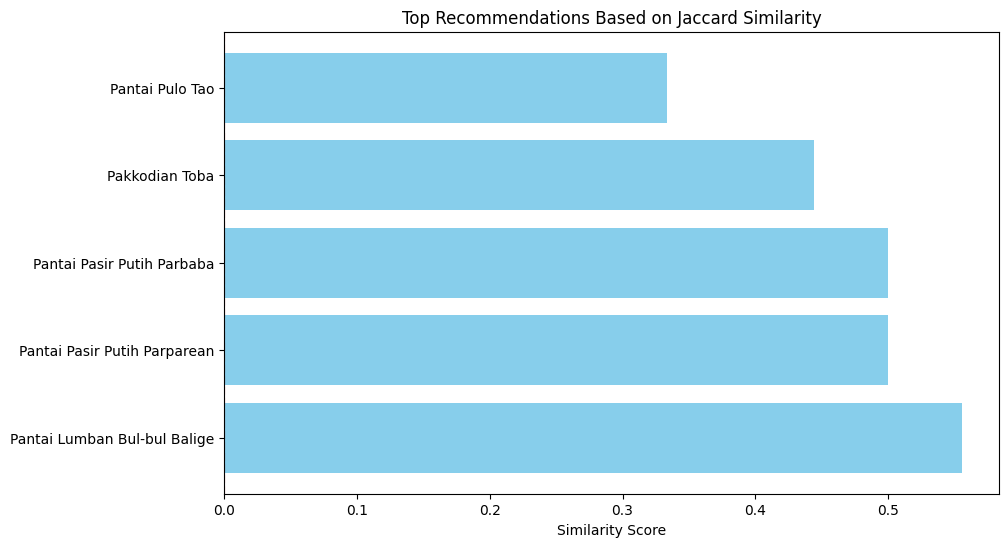

In [11]:
import matplotlib.pyplot as plt  

def plot_recommendations(recommendations):  
    places = [rec[0] for rec in recommendations]  
    similarities = [rec[2] for rec in recommendations]  
    plt.figure(figsize=(10, 6))  
    plt.barh(places, similarities, color='skyblue')  
    plt.xlabel('Similarity Score')  
    plt.title('Top Recommendations Based on Jaccard Similarity')  
    plt.axvline(x=0.0, color='red', linestyle='--')  
    plt.show()  

print(f"Showing recommendations for: {example_place}")  
plot_recommendations(recommendations)

- Fungsi plot_recommendations dibuat untuk memvisualisasikan rekomendasi tempat yang mirip berdasarkan skor kesamaan Jaccard.
- Rekomendasi ditampilkan dalam bentuk grafik batang horizontal yang menunjukkan skor kesamaan masing-masing tempat wisata.

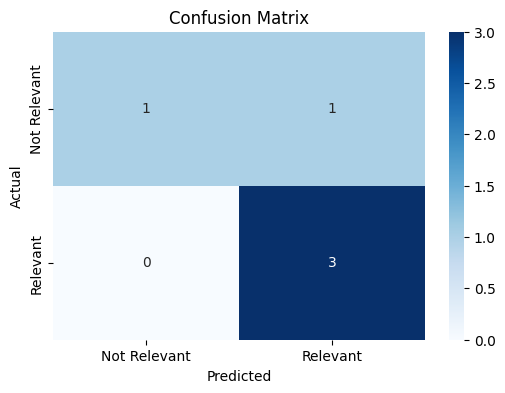

In [12]:
from sklearn.metrics import confusion_matrix  
import seaborn as sns  

# Hitung confusion matrix  
cm = confusion_matrix(y_true, y_pred)  

# Visualisasi confusion matrix  
plt.figure(figsize=(6, 4))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Relevant', 'Relevant'], yticklabels=['Not Relevant', 'Relevant'])  
plt.ylabel('Actual')  
plt.xlabel('Predicted')  
plt.title('Confusion Matrix')  
plt.show()

- Menghitung confusion matrix menggunakan nilai aktual dan prediksi untuk memvisualisasikan kinerja model dalam mengklasifikasikan relevansi.
- Confusion matrix ditampilkan menggunakan heatmap dari Seaborn, memberikan gambaran jelas tentang akurasi model.

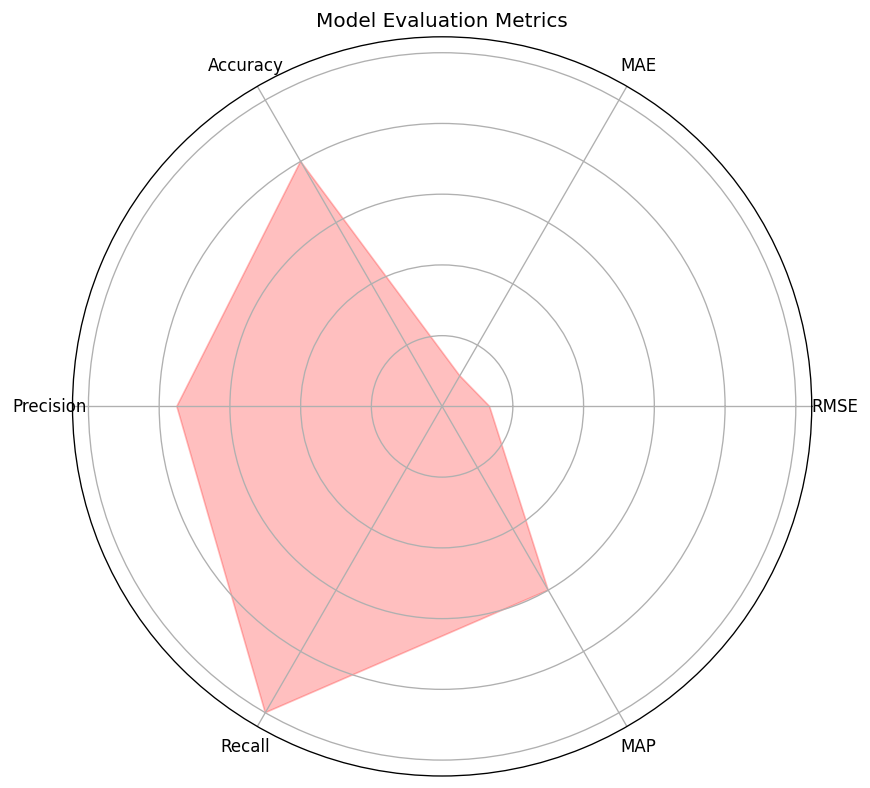

In [16]:
import numpy as np  

labels = ['RMSE', 'MAE', 'Accuracy', 'Precision', 'Recall', 'MAP']  
values = [rmse, mae, accuracy, precision, recall, map_score]  

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()  
values += values[:1]  
angles += angles[:1]  

plt.figure(figsize=(8, 8), dpi=120)  
ax = plt.subplot(111, polar=True)  
ax.fill(angles, values, color='red', alpha=0.25)  
ax.set_yticklabels([])  
ax.set_xticks(angles[:-1])  
ax.set_xticklabels(labels)  
plt.title('Model Evaluation Metrics')  
plt.show()